# The Regression Recommendation System 

### Setting up enviroment

In [55]:
# Python stuff
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

# PySpark stuff
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, BooleanType, DateType, FloatType
from pyspark.sql.functions import isnan, when, count, col, avg, mean, sqrt, desc


# ML stuff
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

22/03/16 02:30:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1658.3 KiB


In [56]:
from pyspark.sql import SparkSession

spark = SparkSession    \
  .builder              \
  .master('yarn')       \
  .appName('spark')     \
  .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

In [57]:
bucket = "big-data-yelp"
spark.conf.set('temporaryGcsBucket', bucket)

In [58]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Preparation

### Import Business Basic Data

In [59]:
table = 'red-formula-339716:gfds.yelp_business_basicdata'
df_b = spark.read.format('bigquery').option('table', table).load()
df_b.show(3)

22/03/16 02:30:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1518.4 KiB
22/03/16 02:30:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1289.6 KiB


+-------------+--------------------+----------------+----------------+---------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+
|int64_field_0|         business_id|            name|         address|     city|state|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|
+-------------+--------------------+----------------+----------------+---------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+
|        10020|2tgAgCI8EJUA16EN4...|     Shaw Direct|W Georgia Street|Vancouver|   BC|       null|    49.285726|   -123.1231553|  2.0|           5|      1|Home Services, Pr...|
|        32306|wzwGYL2M4SvoLgTok...|Austin Tree Pros|            null|   Austin|   TX|       null|    30.267153|    -97.7430608|  2.0|           5|      1|Tree Services, La...|
|        37509|Tsk7LgyqWSwQSumLj...|   Pacific Grill|            null|Vancouver|   BC|       null|49.1981952989|-12

In [60]:
# Filtering to only restuarants in Ohio.
df_b = df_b.filter(df_b.state.like("OH")).filter(df_b.categories.like("%Restaurants%")).drop('int64_field_0', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude')

22/03/16 02:30:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1043.6 KiB


In [61]:
df_b.show(3)

+--------------------+---------------+-----+------------+-------+--------------------+
|         business_id|           name|stars|review_count|is_open|          categories|
+--------------------+---------------+-----+------------+-------+--------------------+
|_rpEhHWZmwnUWe96e...|      Bob Evans|  2.0|          38|      1|Salad, Hotels & T...|
|2R_hRr--5V1krRMfm...|En Super Buffet|  2.0|           5|      0|Chinese, Restaurants|
|H82T5LaYRnL9BispF...| Domino's Pizza|  2.0|          12|      1|Restaurants, Pizz...|
+--------------------+---------------+-----+------------+-------+--------------------+
only showing top 3 rows



### Get Most Commenting Users

Finding the most commenting users in OH.

In [62]:
table = 'red-formula-339716:gfds.yelp_review'
df_r = spark.read.format('bigquery').option('table', table).load()
df_r.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|y-vHCBFQCDMwzsMwJ...|   0|2015-01-06 20:45:46|    0|BB499lAH9E4kZHRRN...|  5.0|I love this place...|     2|6iyM-H6_bI13gl4Zn...|
|P0Ltl7wZFDlHofnPq...|   0|2008-06-25 00:36:30|    1|oCFAPXs9lKU2vmugZ...|  4.0|This is a really ...|     1|FVk12H4Cz4DkRzl8N...|
|Sx0IM4UyHbrRrA6Qe...|   0|2017-07-02 19:55:08|    2|35sl486eWMuDrMbrH...|  1.0|It's odd to see a...|     1|9Mhv0W8S61JbIE8ZY...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows



In [63]:
# Inner join to get only Ohio restaurants.
df_rb = df_r.join(df_b.drop('stars'), on = 'business_id', how = 'inner')

In [64]:
# Finding the most active users
df_rb.groupBy('user_id').count().orderBy('count', ascending = False).show(5, truncate = False)

+----------------------+-----+
|user_id               |count|
+----------------------+-----+
|C1kTSvNdJH_S2bBhitr6ZA|917  |
|R1FVpAyl_BtxHBWdau2VLg|890  |
|JzP5uJjhZb0Vj8J_bn3mOg|748  |
|tgeFUChlh7v8bZFVl2-hjQ|625  |
|wZ0KFPTp1263hDl2M0gXGg|463  |
+----------------------+-----+
only showing top 5 rows



C1kTSvNdJH_S2bBhitr6ZA, R1FVpAyl_BtxHBWdau2VLg, JzP5uJjhZb0Vj8J_bn3mOg, tgeFUChlh7v8bZFVl2-hjQ   
are the most active users.

### Get Top Categories

Getting to top categories in OH restuarants to serve as inputs to the model.

In [65]:
# Using the PySpark explode function to get top categories.
from pyspark.sql.functions import explode, split, col
df_b_explode = df_b.withColumn('categories',(explode(split(col("categories"), ", "))))
df_b_explode.groupby('categories').count().orderBy('count', ascending= 0).show(20, truncate = False)

22/03/16 02:30:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.5 KiB


+-------------------------+-----+
|categories               |count|
+-------------------------+-----+
|Restaurants              |4377 |
|Food                     |1276 |
|Nightlife                |809  |
|Bars                     |784  |
|Fast Food                |776  |
|American (Traditional)   |771  |
|Sandwiches               |719  |
|Pizza                    |679  |
|American (New)           |515  |
|Burgers                  |507  |
|Breakfast & Brunch       |488  |
|Mexican                  |389  |
|Salad                    |353  |
|Coffee & Tea             |320  |
|Chinese                  |304  |
|Italian                  |295  |
|Chicken Wings            |269  |
|Event Planning & Services|244  |
|Sports Bars              |199  |
|Delis                    |178  |
+-------------------------+-----+
only showing top 20 rows



In [66]:
# Top categories!
interested_list = ['Nightlife', 'Bars', 'Fast Food', 'American (Traditional)', 'Sandwiches', 'Pizza', 'American (New)', 'Burgers', 'Breakfast & Brunch', 'Mexican', 'Salad', 'Coffee & Tea', 'Chinese', 'Italian', 'Chicken Wings']

In [67]:
for c in interested_list:
    df_b = df_b.withColumn(c, F.array_contains(split(col("categories"), ', '), c).cast("int"))
df_b = df_b.drop("categories")
df_b.show(3)

+--------------------+---------------+-----+------------+-------+---------+----+---------+----------------------+----------+-----+--------------+-------+------------------+-------+-----+------------+-------+-------+-------------+
|         business_id|           name|stars|review_count|is_open|Nightlife|Bars|Fast Food|American (Traditional)|Sandwiches|Pizza|American (New)|Burgers|Breakfast & Brunch|Mexican|Salad|Coffee & Tea|Chinese|Italian|Chicken Wings|
+--------------------+---------------+-----+------------+-------+---------+----+---------+----------------------+----------+-----+--------------+-------+------------------+-------+-----+------------+-------+-------+-------------+
|_rpEhHWZmwnUWe96e...|      Bob Evans|  2.0|          38|      1|        0|   0|        0|                     1|         0|    0|             0|      0|                 1|      0|    1|           0|      0|      0|            0|
|2R_hRr--5V1krRMfm...|En Super Buffet|  2.0|           5|      0|        0|   0|

In [68]:
# Rename spaces, special punctuation marks, and special character.
df_b = df_b.withColumnRenamed("American (Traditional)","American_Traditional")  \
           .withColumnRenamed("American (New)","American_New")                  \
           .withColumnRenamed("Breakfast & Brunch","Breakfast_Brunch")          \
           .withColumnRenamed("Coffee & Tea","Coffee_Tea")                      \
           .withColumnRenamed("Chicken Wings","Chicken_Wings")                  \
           .withColumnRenamed("Fast Food","Fast_Food")

### Add Parking Info

In [69]:
table = 'red-formula-339716:gfds.yelp_business_businessparking'
df_park = spark.read.format('bigquery').option('table', table).load()
df_park.show(3)

+--------------------+------+-----+------+-----+---------+
|         business_id|garage|  lot|street|valet|validated|
+--------------------+------+-----+------+-----+---------+
|tCbdrRPZA0oiIYSmH...|  true|false| false|false|    false|
|hcRxdDg7DYryCxCoI...|  true|false| false|false|    false|
|jGennaZUr2MsJyRhi...|  true|false| false|false|    false|
+--------------------+------+-----+------+-----+---------+
only showing top 3 rows



In [70]:
# Cast to 1 and 0
cols = ['garage', 'lot', 'street', 'valet', 'validated']
df_park = reduce(lambda df_park, c: df_park.withColumn(c, F.when(df_park[c] == 'false', 0).otherwise(1)), cols, df_park)
df_park.show(3)

+--------------------+------+---+------+-----+---------+
|         business_id|garage|lot|street|valet|validated|
+--------------------+------+---+------+-----+---------+
|tCbdrRPZA0oiIYSmH...|     1|  0|     0|    0|        0|
|hcRxdDg7DYryCxCoI...|     1|  0|     0|    0|        0|
|jGennaZUr2MsJyRhi...|     1|  0|     0|    0|        0|
+--------------------+------+---+------+-----+---------+
only showing top 3 rows



In [71]:
# Join to the business table
df_b = df_b.join(df_park, on = 'business_id', how = 'left').fillna(0)

In [72]:
df_b.show(3)

22/03/16 02:30:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.5 KiB
22/03/16 02:30:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1284.9 KiB


+--------------------+---------------+-----+------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+
|         business_id|           name|stars|review_count|is_open|Nightlife|Bars|Fast_Food|American_Traditional|Sandwiches|Pizza|American_New|Burgers|Breakfast_Brunch|Mexican|Salad|Coffee_Tea|Chinese|Italian|Chicken_Wings|garage|lot|street|valet|validated|
+--------------------+---------------+-----+------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+
|_rpEhHWZmwnUWe96e...|      Bob Evans|  2.0|          38|      1|        0|   0|        0|                   1|         0|    0|           0|      0|               1|      0|    1|         0|      0|      0|            0|     0|  1|

### Add Ambience Info

In [73]:
table = 'red-formula-339716:gfds.yelp_business_ambience'
df_ambience = spark.read.format('bigquery').option('table', table).load()
df_ambience.show(3)

22/03/16 02:30:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.0 KiB


+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
|         business_id|casual|classy|divey|hipster|intimate|romantic|touristy|trendy|upscale|
+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
|arEXRZYu8220bFBJ3...| false| false|false|  false|   false|   false|   false|  true|  false|
|t2xsi7qIN0iwGiOyC...| false| false| true|  false|   false|   false|   false| false|  false|
|N6usNa3_rcYOb8NQ7...| false| false|false|   true|   false|   false|   false| false|  false|
+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
only showing top 3 rows



22/03/16 02:30:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1585.4 KiB


In [74]:
# Cast to 1 and 0
cols = ['casual', 'classy', 'divey', 'hipster', 'intimate', 'romantic', 'touristy', 'trendy', 'upscale']
df_ambience = reduce(lambda df_ambience, c: df_ambience.withColumn(c, F.when(df_ambience[c] == 'false', 0).otherwise(1)), cols, df_ambience)
df_ambience.show(3)

+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
|         business_id|casual|classy|divey|hipster|intimate|romantic|touristy|trendy|upscale|
+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
|arEXRZYu8220bFBJ3...|     0|     0|    0|      0|       0|       0|       0|     1|      0|
|t2xsi7qIN0iwGiOyC...|     0|     0|    1|      0|       0|       0|       0|     0|      0|
|N6usNa3_rcYOb8NQ7...|     0|     0|    0|      1|       0|       0|       0|     0|      0|
+--------------------+------+------+-----+-------+--------+--------+--------+------+-------+
only showing top 3 rows



22/03/16 02:30:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1715.5 KiB


In [75]:
# Join to the business table
df_b = df_b.join(df_ambience, on = 'business_id', how = 'left').fillna(0)

In [76]:
df_b.show(5)

22/03/16 02:30:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1821.3 KiB


+--------------------+--------------------+-----+------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+------+------+-----+-------+--------+--------+--------+------+-------+
|         business_id|                name|stars|review_count|is_open|Nightlife|Bars|Fast_Food|American_Traditional|Sandwiches|Pizza|American_New|Burgers|Breakfast_Brunch|Mexican|Salad|Coffee_Tea|Chinese|Italian|Chicken_Wings|garage|lot|street|valet|validated|casual|classy|divey|hipster|intimate|romantic|touristy|trendy|upscale|
+--------------------+--------------------+-----+------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+------+------+-----+-------+--------+--------+--------+------+-------+
|_rpEhH

### Deal with stars and reviews

Stars and reviews could cause problems in the models. High review with high stars is good, but is bad with low stars.    
Here we minus each restuarant's star by the average star of all restuarants, and time the normalized star by the square root of review count as the star_review_score.
We hope this score could reflect how customers feel about the restuarant better than just using stars and review counts. 

In [77]:
# This is overkill. This function could take a list of column and normalize them all.
def normalize(df, columns):
    aggExpr = []
    for column in columns:
        aggExpr.append(mean(df[column]).alias(column))
    averages = df.agg(*aggExpr).collect()[0]
    selectExpr = ['*']
    for column in columns:
        selectExpr.append((df[column] - averages[column]).alias('normalized_' + column))
    return df.select(selectExpr)

In [78]:
normalize_star = normalize(df_b, ['stars'])
normalize_star1 = normalize_star.withColumn('popularity_score', normalize_star['normalized_stars'] * sqrt(normalize_star['review_count']))
normalize_star1 = normalize_star1.drop('stars', 'review_count', 'normalized_stars')

22/03/16 02:30:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.5 KiB
22/03/16 02:30:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/03/16 02:30:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.0 KiB


In [79]:
normalize_star1.show(3)

22/03/16 02:30:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1585.4 KiB
22/03/16 02:30:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1715.5 KiB
22/03/16 02:30:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1821.3 KiB
22/03/16 02:30:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1913.5 KiB
22/03/16 02:30:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1991.8 KiB


+--------------------+---------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+------+------+-----+-------+--------+--------+--------+------+-------+-------------------+
|         business_id|           name|is_open|Nightlife|Bars|Fast_Food|American_Traditional|Sandwiches|Pizza|American_New|Burgers|Breakfast_Brunch|Mexican|Salad|Coffee_Tea|Chinese|Italian|Chicken_Wings|garage|lot|street|valet|validated|casual|classy|divey|hipster|intimate|romantic|touristy|trendy|upscale|   popularity_score|
+--------------------+---------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+------+------+-----+-------+--------+--------+--------+------+-------+-------------------+
|_rpEhHWZmwnUWe96e.

### Add topic Info

Topic info was generated using NLP topic selection.

In [80]:
table = 'red-formula-339716:gfds.b_id_with_topic'
df_topic = spark.read.format('bigquery').option('table', table).load()
df_topic.show(3)

22/03/16 02:30:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+--------------------+-------+
|         business_id|topicID|
+--------------------+-------+
|-AIj0yS_K7tnCKOtK...|      0|
|0GAVuSOBf2LD8G7ce...|      0|
|1vtDo34yXIToPOQty...|      0|
+--------------------+-------+
only showing top 3 rows



22/03/16 02:30:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [81]:
topics = df_topic.select("topicID").distinct().rdd.flatMap(lambda x: x).collect()
topic_expr = [F.when(F.col("topicID") == ty, 1).otherwise(0).alias("is_topic_" + str(ty)) for ty in topics]

22/03/16 02:30:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1984.3 KiB


In [82]:
df_topic = df_topic.select("business_id", *topic_expr)

In [83]:
df = normalize_star1.join(df_topic, on = 'business_id', how = 'left')

In [84]:
df.columns

['business_id',
 'name',
 'is_open',
 'Nightlife',
 'Bars',
 'Fast_Food',
 'American_Traditional',
 'Sandwiches',
 'Pizza',
 'American_New',
 'Burgers',
 'Breakfast_Brunch',
 'Mexican',
 'Salad',
 'Coffee_Tea',
 'Chinese',
 'Italian',
 'Chicken_Wings',
 'garage',
 'lot',
 'street',
 'valet',
 'validated',
 'casual',
 'classy',
 'divey',
 'hipster',
 'intimate',
 'romantic',
 'touristy',
 'trendy',
 'upscale',
 'popularity_score',
 'is_topic_0',
 'is_topic_6',
 'is_topic_5',
 'is_topic_1',
 'is_topic_3',
 'is_topic_2',
 'is_topic_4']

In [85]:
df.show(3)

22/03/16 02:30:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.5 KiB
22/03/16 02:30:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/03/16 02:30:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.0 KiB
22/03/16 02:30:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1585.4 KiB


+--------------------+---------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+-------------+------+---+------+-----+---------+------+------+-----+-------+--------+--------+--------+------+-------+-------------------+----------+----------+----------+----------+----------+----------+----------+
|         business_id|           name|is_open|Nightlife|Bars|Fast_Food|American_Traditional|Sandwiches|Pizza|American_New|Burgers|Breakfast_Brunch|Mexican|Salad|Coffee_Tea|Chinese|Italian|Chicken_Wings|garage|lot|street|valet|validated|casual|classy|divey|hipster|intimate|romantic|touristy|trendy|upscale|   popularity_score|is_topic_0|is_topic_6|is_topic_5|is_topic_1|is_topic_3|is_topic_2|is_topic_4|
+--------------------+---------------+-------+---------+----+---------+--------------------+----------+-----+------------+-------+----------------+-------+-----+----------+-------+-------+----

22/03/16 02:30:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1715.5 KiB


### Check point

Saving the data back to BigQuery.

In [86]:
table = 'red-formula-339716:gfds.business_cleanedishV1'
df.write.format('bigquery') \
  .mode("overwrite")        \
  .option('table', table)   \
  .save()

22/03/16 02:30:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1821.3 KiB
22/03/16 02:30:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1913.5 KiB
22/03/16 02:30:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1991.8 KiB
22/03/16 02:30:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/03/16 02:30:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/03/16 02:30:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1984.3 KiB
22/03/16 02:30:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1850.8 KiB
22/03/16 02:31:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1291.4 KiB
22/03/16 02:31:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting l

## Run Models

### Check point

Read the data from BigQuery.

In [87]:
table = 'red-formula-339716:gfds.business_cleanedishV1'
df = spark.read.format('bigquery').option('table', table).load()

### VectorAssembler

Spark ML seems to only take one column as inpuut, so we use VectorAssembler to combine all the features.

In [88]:
inputs = ['is_open', 'American_New', 'American_Traditional', 'Bars',        \
 'Breakfast_Brunch', 'Burgers', 'Chicken_Wings', 'Chinese', 'Coffee_Tea',   \
 'Fast_Food', 'Italian', 'Mexican', 'Nightlife', 'Pizza', 'Salad',          \
 'Sandwiches', 'garage', 'lot', 'street', 'valet', 'validated', 'casual',   \
 'classy', 'divey', 'hipster', 'intimate', 'romantic', 'touristy','trendy', \
 'upscale', 'popularity_score', 'is_topic_0', 'is_topic_1', 'is_topic_2',  \
 'is_topic_3', 'is_topic_4', 'is_topic_5', 'is_topic_6']

In [89]:
assembler = VectorAssembler(inputCols = inputs, outputCol="features")
spDF = assembler.transform(df).drop(*inputs)

spDF.show(3)

+--------------------+----+--------------------+
|         business_id|name|            features|
+--------------------+----+--------------------+
|u8xKhVGwBSlcBbH-e...| KFC|(38,[0,6,9,30,34]...|
|8KuQwWcHwYmqV7FyT...| KFC|(38,[0,6,9,30,34]...|
|-0mDPayQbOuJBw72Q...| KFC|(38,[0,6,9,30,34]...|
+--------------------+----+--------------------+
only showing top 3 rows



Top users: C1kTSvNdJH_S2bBhitr6ZA, R1FVpAyl_BtxHBWdau2VLg, JzP5uJjhZb0Vj8J_bn3mOg, tgeFUChlh7v8bZFVl2-hjQ

In [90]:
# Preparing data for top user
df_r_user1 = df_r.filter(df_r.user_id == 'C1kTSvNdJH_S2bBhitr6ZA')
df_r_user1 = df_r_user1.select('business_id', 'stars', 'user_id').join(spDF, on = 'business_id', how = 'inner')

In [91]:
training, test = df_r_user1.randomSplit([0.8,0.2])

In [92]:
training.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- features: vector (nullable = true)



In [93]:
training.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|         business_id|stars|             user_id|                name|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|-XsgHkrblivxrbJpt...|  4.0|C1kTSvNdJH_S2bBhi...|     Firdous Express|(38,[0,21,30,32],...|
|0jFrTHMEyIlHX0i_1...|  5.0|C1kTSvNdJH_S2bBhi...|       Belle's Bread|(38,[0,17,21,22,3...|
|1c6PESqBJ2EQrjIVZ...|  5.0|C1kTSvNdJH_S2bBhi...|Wholly Joe's Chic...|(38,[9,13,17,21,3...|
|3Qozg5zj-PelhTcdg...|  4.0|C1kTSvNdJH_S2bBhi...|      Salvi's Bistro|(38,[10,17,21,30,...|
|5ulpV50MTkudwv-4a...|  4.0|C1kTSvNdJH_S2bBhi...|        Waffle House|(38,[0,2,4,17,21,...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



### LinearRegression

In [40]:
lr = LinearRegression(featuresCol = 'features', labelCol='stars')
lrm = lr.fit(training)
predictions_lrm = lrm.transform(test)
train_pred_lrm = lrm.transform(training)

22/03/12 02:19:29 WARN org.apache.spark.ml.util.Instrumentation: [e9c6fbfb] regParam is zero, which might cause numerical instability and overfitting.
22/03/12 02:19:32 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/03/12 02:19:32 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/03/12 02:19:32 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/03/12 02:19:32 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/03/12 02:19:32 WARN org.apache.spark.ml.util.Instrumentation: [e9c6fbfb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [41]:
# RMSE
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

rmse_test = evaluator.evaluate(predictions_lrm)
rmse_train = evaluator.evaluate(train_pred_lrm)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

#R2
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="r2", throughOrigin = True)

r2_test = evaluator.evaluate(predictions_lrm)
r2_train = evaluator.evaluate(train_pred_lrm)
print("R2 on test data = %g" % r2_test)
print("R2 on train data = %g" % r2_train)

Root Mean Squared Error (RMSE) on test data = 0.937383
Root Mean Squared Error (RMSE) on train data = 0.933318


R2 on test data = 0.946286
R2 on train data = 0.947039


### DecisionTreeRegressor

In [42]:
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='stars')
dtm = dt.fit(training)
predictions_dtm = dtm.transform(test)
train_pred_dtm = dtm.transform(training)

In [43]:
#RMSE
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

rmse_test = evaluator.evaluate(predictions_dtm)
rmse_train = evaluator.evaluate(train_pred_dtm)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

#F2
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="r2", throughOrigin = True)

r2_test = evaluator.evaluate(predictions_dtm)
r2_train = evaluator.evaluate(train_pred_dtm)
print("R2 on test data = %g" % r2_test)
print("R2 on train data = %g" % r2_train)

Root Mean Squared Error (RMSE) on test data = 0.974007
Root Mean Squared Error (RMSE) on train data = 0.877509
R2 on test data = 0.942007
R2 on train data = 0.953183


### RandomForestRegressor

In [44]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='stars')
rfm = rf.fit(training)
predictions_rfm = rfm.transform(test)
train_pred_rfm = rfm.transform(training)

In [45]:
#RMSE
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

rmse_test = evaluator.evaluate(predictions_rfm)
rmse_train = evaluator.evaluate(train_pred_rfm)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

#F2
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="r2", throughOrigin = True)

r2_test = evaluator.evaluate(predictions_rfm)
r2_train = evaluator.evaluate(train_pred_rfm)
print("R2 on test data = %g" % r2_test)
print("R2 on train data = %g" % r2_train)

Root Mean Squared Error (RMSE) on test data = 0.893568
Root Mean Squared Error (RMSE) on train data = 0.85789
R2 on test data = 0.95119
R2 on train data = 0.955253


### GBTRegressor

In [45]:
gbt = GBTRegressor(featuresCol = 'features', labelCol='stars', maxDepth=8, maxBins=16, maxIter=40, stepSize=0.05)
gbtm = gbt.fit(training)
predictions_gbtm = gbtm.transform(test)
train_pred_gbtm = gbtm.transform(training)

In [46]:
#RSME
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

rmse_test = evaluator.evaluate(predictions_gbtm)
rmse_train = evaluator.evaluate(train_pred_gbtm)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

#F2
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="r2", throughOrigin = True)

r2_test = evaluator.evaluate(predictions_gbtm)
r2_train = evaluator.evaluate(train_pred_gbtm)
print("R2 on test data = %g" % r2_test)
print("R2 on train data = %g" % r2_train)

Root Mean Squared Error (RMSE) on test data = 1.17312
Root Mean Squared Error (RMSE) on train data = 0.50573


R2 on test data = 0.912384
R2 on train data = 0.984607


## Select Random Forest to Run Grid Search

#### Using CrossValidator to finetune parameters

In [94]:
rf = RandomForestRegressor(labelCol="stars", featuresCol="features")

In [95]:
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 5)]) \
    .build()

evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

In [96]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [97]:
cvModel = crossval.fit(training)

22/03/16 02:33:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1087.8 KiB
22/03/16 02:33:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1173.3 KiB
22/03/16 02:33:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1243.3 KiB
22/03/16 02:33:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1087.8 KiB
22/03/16 02:33:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1173.3 KiB
22/03/16 02:33:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1243.3 KiB
22/03/16 02:33:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1302.6 KiB
22/03/16 02:33:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1347.9 KiB
22/03/16 02:33:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

22/03/16 02:34:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/03/16 02:34:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1996.5 KiB
22/03/16 02:34:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.3 KiB
22/03/16 02:34:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1906.1 KiB
22/03/16 02:34:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1715.3 KiB
22/03/16 02:34:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1525.1 KiB
22/03/16 02:34:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1181.2 KiB
22/03/16 02:35:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1033.9 KiB
22/03/16 02:35:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcastin

22/03/16 02:35:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/03/16 02:35:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/03/16 02:35:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/03/16 02:35:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/03/16 02:35:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1900.5 KiB
22/03/16 02:35:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1525.8 KiB
22/03/16 02:35:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1052.2 KiB
22/03/16 02:35:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1266.7 KiB
22/03/16 02:35:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large t

22/03/16 02:37:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.1 KiB
22/03/16 02:37:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1641.1 KiB
22/03/16 02:37:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1820.1 KiB
22/03/16 02:37:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1975.6 KiB
22/03/16 02:37:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/03/16 02:37:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
22/03/16 02:37:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1223.5 KiB
22/03/16 02:37:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.1 KiB
22/03/16 02:37:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcastin

#### Predicting on test and training sets

In [98]:
predictions_bestModel = cvModel.transform(test)
training_bestModel = cvModel.transform(training)

Evaluator - RMSE: 0.87 on test data

In [99]:
#RMSE
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="rmse")

rmse_test = evaluator.evaluate(predictions_bestModel)
rmse_train = evaluator.evaluate(training_bestModel)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

#F2
evaluator = RegressionEvaluator(labelCol="stars",
                                predictionCol="prediction",
                                metricName="r2", throughOrigin = True)

r2_test = evaluator.evaluate(predictions_bestModel)
r2_train = evaluator.evaluate(training_bestModel)
print("R2 on test data = %g" % r2_test)
print("R2 on train data = %g" % r2_train)

Root Mean Squared Error (RMSE) on test data = 0.92972
Root Mean Squared Error (RMSE) on train data = 0.6625


R2 on test data = 0.945058
R2 on train data = 0.973518


In [105]:
predictions_bestModel.select('business_id', 'user_id', 'name', 'stars', 'prediction').distinct().orderBy(desc('prediction')).show(30)

+--------------------+--------------------+--------------------+-----+------------------+
|         business_id|             user_id|                name|stars|        prediction|
+--------------------+--------------------+--------------------+-----+------------------+
|D6vNP2CBjP3Lg7Xid...|C1kTSvNdJH_S2bBhi...|Columbus Fish Market|  5.0|4.9700932224741745|
|B_W4Nq3-iFWV2ato5...|C1kTSvNdJH_S2bBhi...|The Refectory Res...|  5.0|  4.95669191919192|
|ewFMsE_X1PcS09yuO...|C1kTSvNdJH_S2bBhi...|J. Gilbert's Wood...|  5.0| 4.936651860157553|
|oRqgWTs4YBjEWCoz0...|C1kTSvNdJH_S2bBhi...|Gallo's Kitchen +...|  5.0| 4.932596473635128|
|yKyKvEqumEes4FOQY...|C1kTSvNdJH_S2bBhi...|  The Top Steakhouse|  5.0|4.8913504919596456|
|WQSziTOUaS36KC1es...|C1kTSvNdJH_S2bBhi...|       J Alexander's|  5.0| 4.858799435035911|
|4ergn03AcRW2kzgvZ...|C1kTSvNdJH_S2bBhi...|      The Old Mohawk|  4.0| 4.798652349828822|
|D8Va5ZW8snfom8pIs...|C1kTSvNdJH_S2bBhi...|German Village Co...|  4.0|  4.78269976268636|
|Bn3gS9n9F

In [101]:
bestmodel = cvModel.bestModel

In [102]:
pd_Importance = pd.DataFrame(list(zip(assembler.getInputCols(), bestmodel.featureImportances)), columns = ['Feature', 'Importance'])
pd_Importance = pd_Importance.sort_values('Importance', ascending = False, axis = 0)
pd_Importance['Importance'] = pd_Importance['Importance'].map("{:.2%}".format)
pd_Importance.head(10)

,Feature,Importance
30,popularity_score,22.84%
10,Italian,4.48%
17,lot,4.27%
22,classy,4.21%
33,is_topic_2,4.18%
0,is_open,3.97%
21,casual,3.75%
4,Breakfast_Brunch,3.52%
1,American_New,3.16%
36,is_topic_5,2.98%


In [108]:
pd_Importance['Importance'] = pd_Importance['Importance'].str.strip('%').astype(float)

In [117]:
pd_Importance = pd_Importance.set_index("Feature")

In [122]:
pd_Importance.head()

,Importance
Feature,
popularity_score,22.84
Italian,4.48
lot,4.27
classy,4.21
is_topic_2,4.18


<AxesSubplot:ylabel='Feature'>

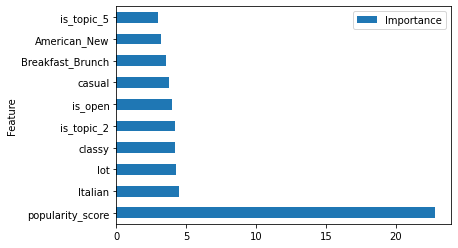

In [128]:
pd_Importance[:10].plot.barh()